In [1]:
import os
import io
import json
import numpy as np
from glob import glob
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [15]:
def load_csv(file):
    data = pd.read_csv(file)
    return data

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def save_df(df, save_file_to=None):
    assert save_file_to is not None, 'save_file_to is None'
    df.to_csv(save_file_to, index=False)

class ProcessLogs:
    def __init__(self, pattern='./logs/*/*/*/rank_0/'):
        self.args_files = glob(pattern+'args.json')
        self.is_valid = len(self.args_files) > 0
        assert self.is_valid, f'''Invalid pattern: {pattern}, {len(self.args_files)} args json files found'''
        self.init()

    def init(self):
        self.results = {}
        self.invalid_exps = []
        num = len(self.args_files)
        for i in range(num):
            if '0.2' in self.args_files[i] or '0.5' in self.args_files[i]:
                continue
            args = load_json(self.args_files[i])
            key, keys2values = self.args2key(args)
            
            csv_file = glob(self.args_files[i].replace('args.json', 'overall.csv'))
            if len(csv_file) == 0:
                print(self.args_files[i])
                self.invalid_exps.append(self.args_files[i])
                # print(self.args_files[i].replace('rank_0/args.json', ''))
                ThroughPut = 0
                GPU_Peak_Memory = 0
                GPU_Peak_Memory_std = 0
                CPU_Peak_Memory = 0
                CPU_Peak_Memory_std = 0
                # GPU_Peak_Memory = 0
                # GPU_Peak_Memory_std = 0
                BatchTime_mean = 0
                BatchTime_std = 0
                is_valid = False
            else:
                csv_file = csv_file[0]
                csv_data = load_csv(csv_file)
                ThroughPut = csv_data.iloc[-1, 1]
                GPU_Peak_Memory = csv_data['PeakGPU (MB)'][0]
                GPU_Peak_Memory_std = csv_data['PeakGPU (MB)'][2]
                CPU_Peak_Memory = csv_data['PeakCPU (MB)'][0]
                CPU_Peak_Memory_std = csv_data['PeakCPU (MB)'][2]
                # GPU_Peak_Memory = csv_data['update_gp'][0]
                # GPU_Peak_Memory_std = csv_data['update_gp'][1]
                BatchTime_mean = csv_data['Batch Time'][1]
                BatchTime_std = csv_data['Batch Time'][2]
                is_valid = True
            value = {
                'ThroughPut': ThroughPut,
                'GPU_Peak_Memory': GPU_Peak_Memory,
                'GPU_Peak_Memory_std': GPU_Peak_Memory_std,
                'CPU_Peak_Memory': CPU_Peak_Memory,
                'CPU_Peak_Memory_std': CPU_Peak_Memory_std,
                'BatchTime_mean': BatchTime_mean,
                'BatchTime_std': BatchTime_std,
                'args': args,
                'keys2values': keys2values,
                'path': self.args_files[i].replace('rank_0/args.json', ''),
                'is_valid': is_valid
            }
            if key in self.results:
                # if ThroughPut < self.results[key]['ThroughPut']:
                #     print(key, value)
                #     continue
                key += f'_v{i}'
                # print(f'Warning: key {key} already exists')
            self.results[key] = value
        print(f"{len(self.invalid_exps)} exps are invalid.")

    def args2key(self, args: dict):
        dist_backend = args['dist_backend']
        gpus = args['gpus']
        model = args['model']
        img_size = args['img_size']
        batch_size = args['batch_size']
        exp_name = args['exp_name']
        
        ##### parallelism
        use_zero = args['use_zero']
        shardstrategy = args['shardstrategy'] # for zero
        nof = args['nof'] # for zero
        use_fp16 = args['use_fp16']
        use_pipeline = args['use_pipeline']
        keys = ['dist_backend', 'gpus', 'model', 'img_size', 'batch_size',
                'exp_name', 'use_zero', 'shardstrategy', 'nof', 'use_fp16', 'use_pipeline']
        keys2values = {k: args[k] for k in keys}
        
        key = f'{model}_{dist_backend}_gpus{gpus}_{batch_size}x{img_size}x{img_size}'
        if use_zero == 1:
            key += f'_zero_{shardstrategy}_nof{nof}'
        if use_fp16 == 1:
            key += '_fp16'
        if use_pipeline == 1:
            key += f'_pipeline'
        key += f'_{exp_name}'
        return key, keys2values

    def anomaly_detection(self, df):
        # 按照指定参数进行分组
        groups = df.groupby(['model', 'gpus', 'batch_size', 'img_size', 'zero', 'shardstrategy', 'nof', 'fp16', 'pipeline'])

        # 对比相同参数下的 ThroughPut 差异，找到异常样本点
        for name, group in groups:
            throughputs = group['ThroughPut']
            mean_throughput = throughputs.mean()
            std_throughput = throughputs.std()
            for i, throughput in throughputs.iteritems():
                if abs(throughput - mean_throughput) > 3 * std_throughput:
                    df.at[i, 'is_valid'] = False
                    print(f"异常样本点：{group.iloc[i]['path']}")
                else:
                    df.at[i, 'is_valid'] = True
        return df

    def export_all(self, save_file_to=None):
        content = 'model,gpus,batch_size,img_size,fp16,pipeline,zero,shardstrategy,nof,ThroughPut,GPU_Peak_Memory,GPU_Peak_Memory_std,CPU_Peak_Memory,CPU_Peak_Memory_std,BatchTime_mean,BatchTime_std,path\n'
        template = '{model},{gpus},{batch_size},{img_size},{use_fp16},{use_pipeline},{use_zero},{shardstrategy},{nof},{ThroughPut},{GPU_Peak_Memory},{GPU_Peak_Memory_std},{CPU_Peak_Memory},{CPU_Peak_Memory_std},{BatchTime_mean},{BatchTime_std},{path}\n'
        for key, val in self.results.items():
            dicts = deepcopy(val['keys2values'])
            for x in ['ThroughPut', 'GPU_Peak_Memory', 'GPU_Peak_Memory_std', 'CPU_Peak_Memory', 'CPU_Peak_Memory_std', 'BatchTime_mean', 'BatchTime_std', 'path']:
                dicts[x] = val[x]
            content += template.format(**dicts)
        df = pd.read_csv(io.StringIO(content))
        df = self.anomaly_detection(df)
        save_df(df, save_file_to)
        return df



In [16]:
pl = ProcessLogs()
df = pl.export_all(save_file_to='./results.csv')


./logs/vit_h/colossalai_gpu4_64x224x224_zero_btss_nof1.0__/2023-03-22-03:10:15_AM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_64x32x32__/2023-03-20-08:44:39_PM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_64x32x32_fp16__/2023-03-20-08:45:23_PM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_128x32x32__/2023-03-20-08:53:00_PM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_128x32x32__/2023-03-21-03:00:34_AM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_128x32x32_fp16__/2023-03-20-08:53:43_PM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_128x32x32_fp16__/2023-03-21-03:01:18_AM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_256x32x32__/2023-03-20-09:01:35_PM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_256x32x32_fp16__/2023-03-20-09:02:19_PM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_8x224x224__/2023-03-21-12:08:46_AM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_8x224x224_fp16__/2023-03-21-12:09:34_AM/rank_0/args.json
./logs/vit_g/colossalai_gpu4_16x224x224__/2023-03-21-12:17:28_AM/ran

In [17]:
# model_name = 'vit_b'
# darts_df = df[df['model']==model_name][df['gpus']==4][df['img_size']==32].sort_values(by=['batch_size', 'fp16', 'pipeline', 'zero', 'shardstrategy', 'nof'])
# darts_df.to_csv(f'./results/{model_name}_df.csv')
new_df = df.sort_values(by=['model', 'gpus', 'img_size', 'batch_size', 'fp16', 'pipeline', 'zero', 'shardstrategy', 'nof'])
new_df.to_csv(f'./results/all_df.csv')
with pd.ExcelWriter('./results/all_df.xlsx') as writer:
    new_df.to_excel(writer, sheet_name='all_df', index=False)
# new_df

In [18]:
new_df[new_df['model']=='vit_b'][new_df['img_size']==32][new_df['gpus']==4]

/tmp/ipykernel_5234/2902250862.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df[new_df['model']=='vit_b'][new_df['img_size']==32][new_df['gpus']==4]


,model,gpus,batch_size,img_size,fp16,pipeline,zero,shardstrategy,nof,ThroughPut,GPU_Peak_Memory,GPU_Peak_Memory_std,CPU_Peak_Memory,CPU_Peak_Memory_std,BatchTime_mean,BatchTime_std,path,is_valid
0,vit_b,4,256,32,0,0,0,btss,0.0,10914.5722,2419.1118,16.0679,2385.3945,0.5784,0.0938,0.0039,./logs/vit_b/colossalai_gpu4_256x32x32__/2023-...,True
4,vit_b,4,256,32,0,0,1,btss,0.0,3673.0381,1316.7549,5.0031,2426.0078,0.1945,0.2788,0.0094,./logs/vit_b/colossalai_gpu4_256x32x32_zero_bt...,True
5,vit_b,4,256,32,0,0,1,btss,0.0,3678.4212,1320.5908,10.2155,2430.0781,0.1853,0.2784,0.0085,./logs/vit_b/colossalai_gpu4_256x32x32_zero_bt...,True
65,vit_b,4,256,32,0,0,1,btss,1.0,3625.9632,1333.9404,15.6722,2223.6094,0.1140,0.2824,0.0070,./logs/vit_b/colossalai_gpu4_256x32x32_zero_bt...,True
2,vit_b,4,256,32,0,1,0,btss,0.0,9937.3363,387.5000,2.5890,2682.4102,0.1346,0.1030,0.0026,./logs/vit_b/colossalai_gpu4_256x32x32_pipelin...,True
1,vit_b,4,256,32,1,0,0,btss,0.0,8461.2301,1574.3892,6.9373,2422.7656,0.1960,0.1210,0.0053,./logs/vit_b/colossalai_gpu4_256x32x32_fp16__/...,True
3,vit_b,4,256,32,1,1,0,btss,0.0,9741.2249,304.7202,1.0207,2760.2344,0.3217,0.1051,0.0024,./logs/vit_b/colossalai_gpu4_256x32x32_pipelin...,True
6,vit_b,4,512,32,0,0,0,btss,0.0,15535.1048,3090.1396,20.0152,2172.4336,0.1653,0.1318,0.0051,./logs/vit_b/colossalai_gpu4_512x32x32__/2023-...,True
10,vit_b,4,512,32,0,0,1,btss,0.0,7295.9334,2136.3467,12.5271,2230.1367,0.1204,0.2807,0.0085,./logs/vit_b/colossalai_gpu4_512x32x32_zero_bt...,True
36,vit_b,4,512,32,0,0,1,btss,1.0,7041.3069,2139.1592,14.8044,2228.7578,0.1466,0.2909,0.0105,./logs/vit_b/colossalai_gpu4_512x32x32_zero_bt...,True


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(origin_df, model_name, gpus, img_size):
    # 读取数据文件
    df1 = origin_df.copy(deep=True)

    # 筛选出 gpus=2 的数据
    df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])
    # print(df1)
    # 将数据按照 fp16、pipeline、zero、nof 四个并行策略分组
    groups = df1.groupby(['fp16', 'pipeline', 'zero', 'nof'])

    # 绘制柱状图和箱图
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    bar_width = 0.2
    opacity = 0.8
    colors = [
    '#002c53',
    '#ffa510',
    '#0c84c6',
    '#f74d4d',
    '#2455a4',
    '#41b7ac',
    ]

    setting2name = {
            (0, 0, 0, 0.0): 'DDP',
            (0, 0, 1, 0.0): 'ZeRO',
            (0, 0, 1, 1.0): 'ZeRO-Offload',
            (0, 1, 0, 0.0): 'Pipeline',
            (1, 0, 0, 0.0): 'DDP-FP16',
            (1, 1, 0, 0.0): 'Pipeline-FP16'
    }
    length = len(groups)
    bar_width = 1
    interval = bar_width * length + 2
    batch_size = None
    for i, (setting, group) in enumerate(groups):
        # print(setting)
        label = setting2name[setting]
        # print(group['batch_size'], '\n', group['ThroughPut'])
        
        # 绘制 Throughput 柱状图
        batch_size = group['batch_size'].values.tolist()
        x = [j*interval + i * bar_width for j in range(len(batch_size))]
        # print(x)
        ax1.bar(x, height=group['ThroughPut'], color=colors[i%length], width=bar_width, align='center', label=label)
        
        # 绘制 GPU Peak Memory 箱图
        x = [j*interval + (len(groups)-1)//2 * bar_width for j in range(len(batch_size))]
        ax2.plot(x, group['GPU_Peak_Memory'], marker='o', color=colors[i%length], label=label)

    # 设置坐标轴和图例
    xstick = [j*interval + i//2 * bar_width for j in range(len(batch_size))]
    xlabels = group['batch_size'].values.tolist()
    ax1.set_xticks(xstick)
    ax1.set_xticklabels(xlabels)

    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Throughput (imgs/sec)')
    ax2.set_ylabel('GPU Peak Memory (MB)')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize='small')
    plt.title(f'Performance Comparison of {model_name} on {gpus} GPUs with 3x{img_size}x{img_size} input')
    plt.show()



/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


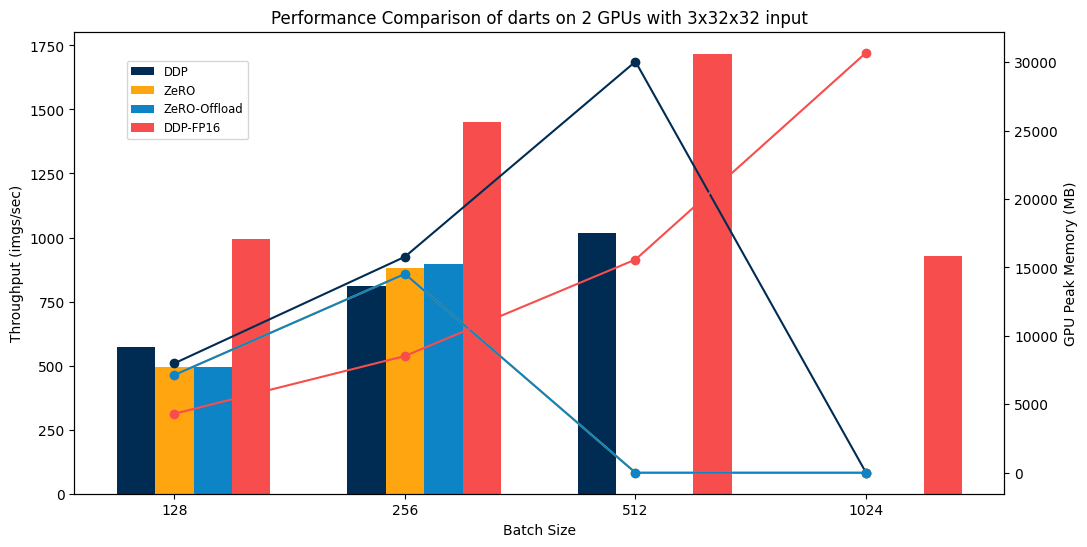

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


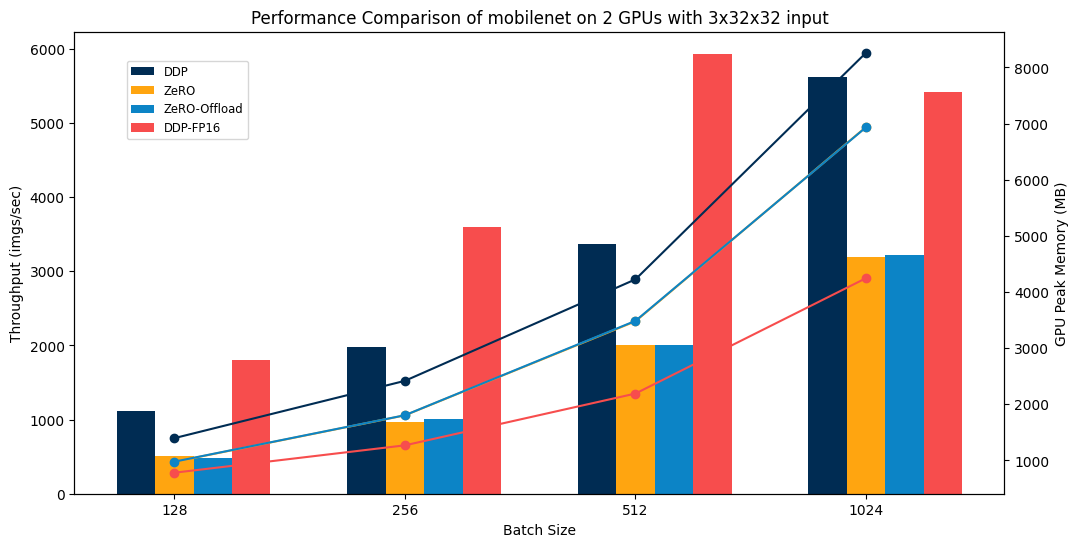

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])
/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


error: ofa due to object of type 'NoneType' has no len()


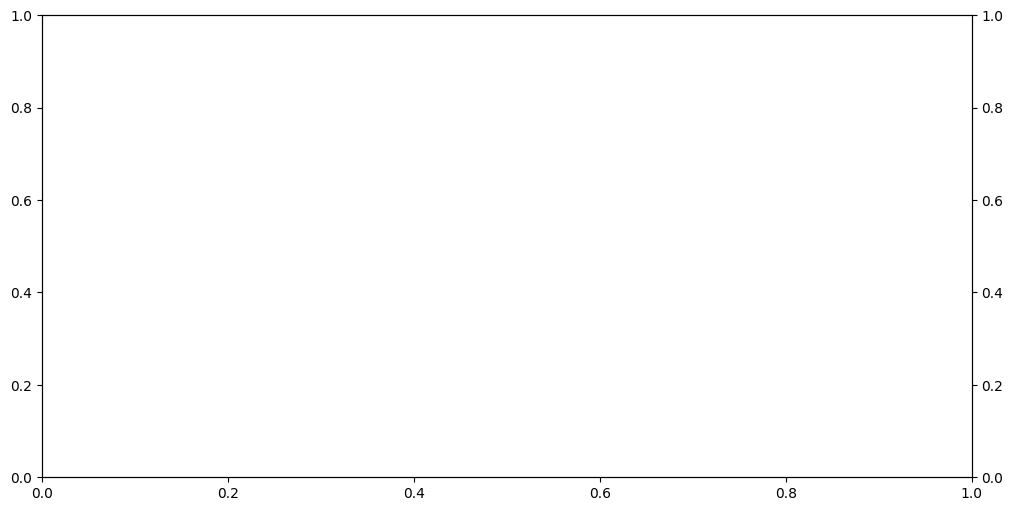

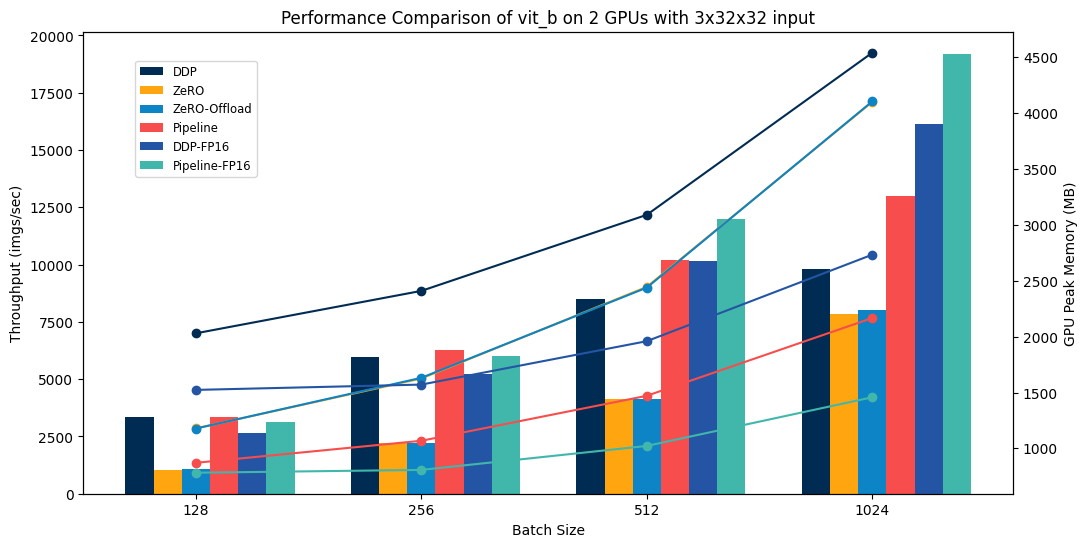

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


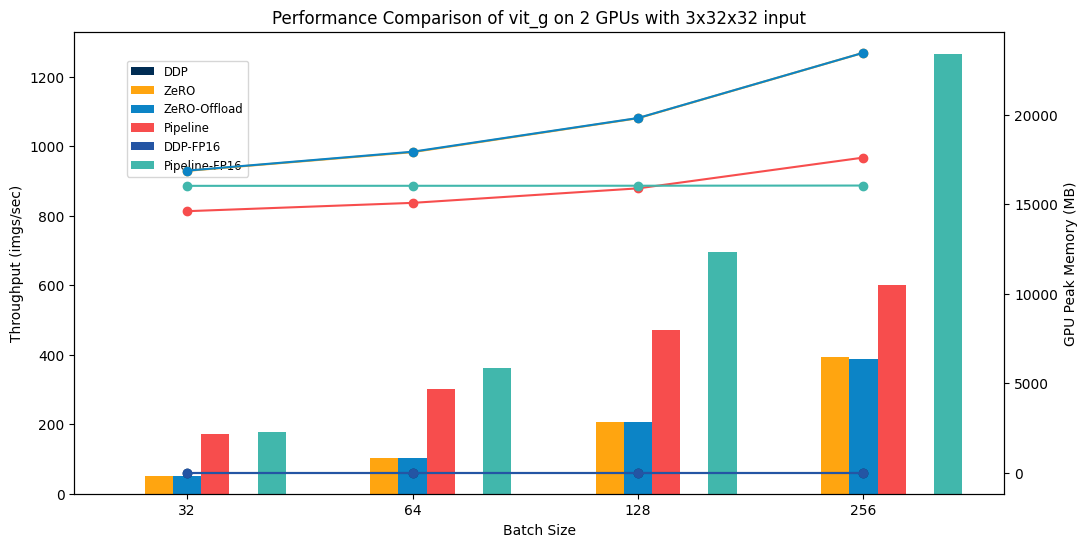

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


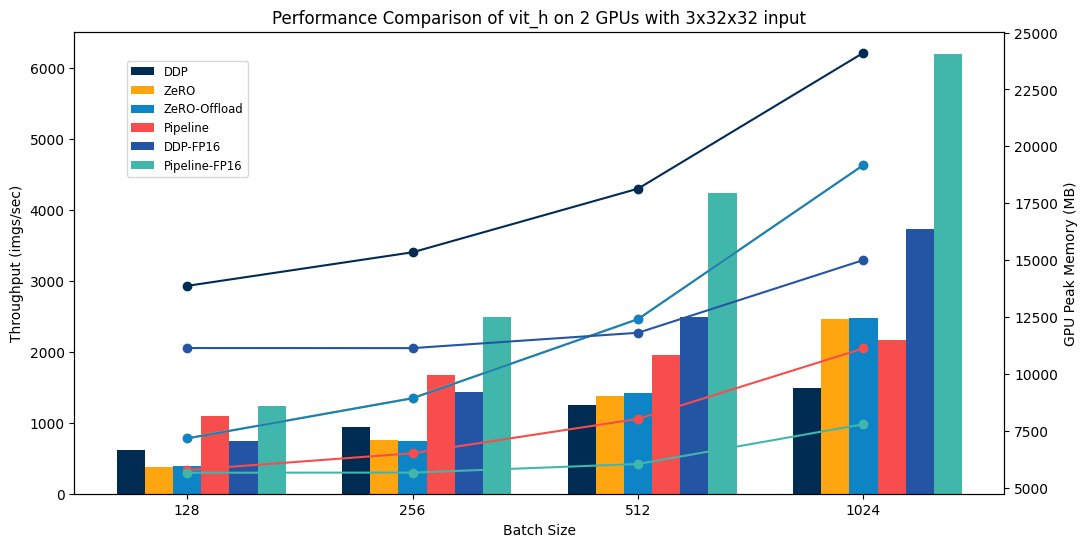

In [13]:
for model in new_df['model'].unique():
    try:
        plot(new_df, model, 2, 32)
    except Exception as e:
        print(f'error: {model} due to {e}')

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


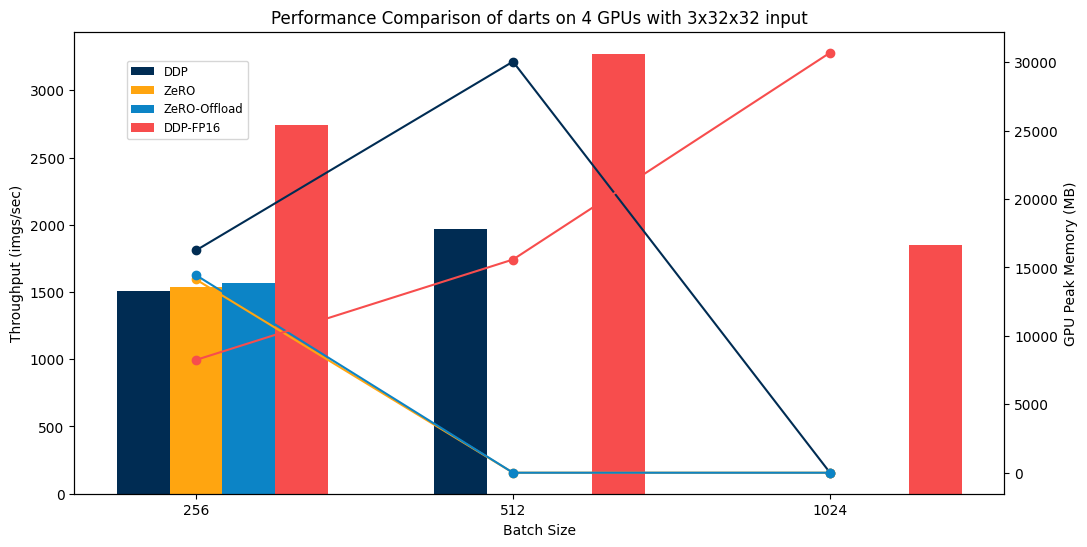

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


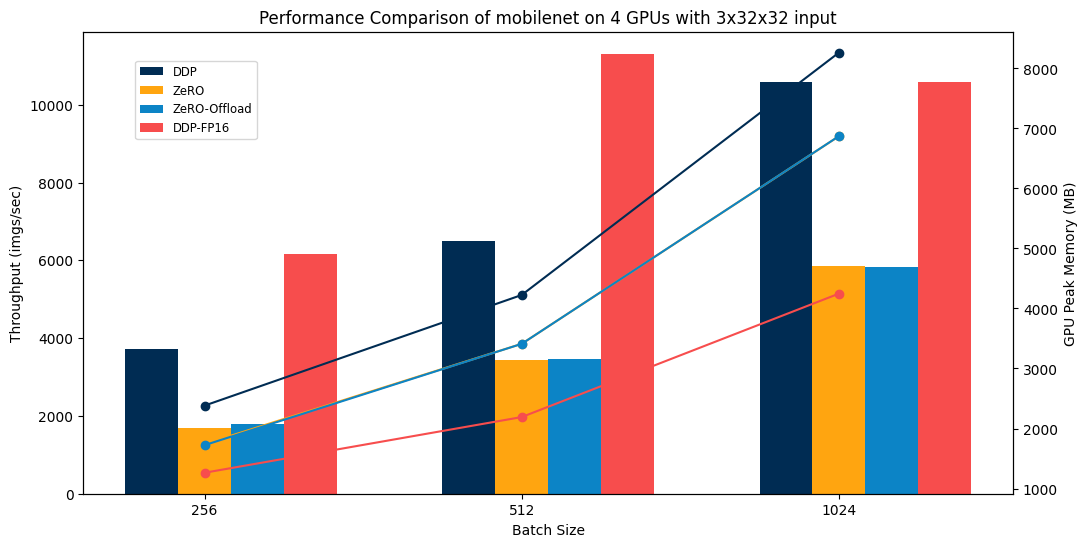

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


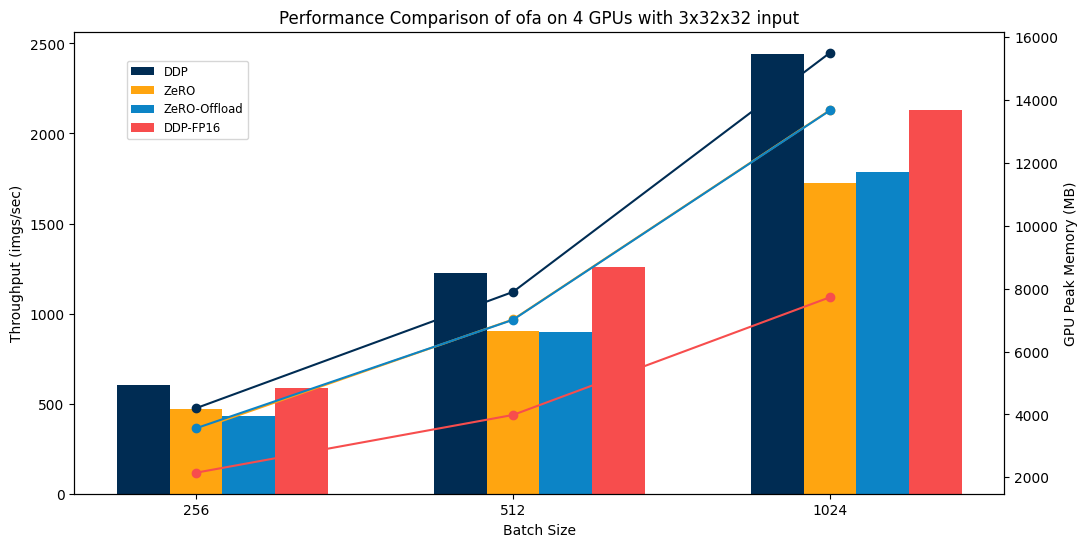

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


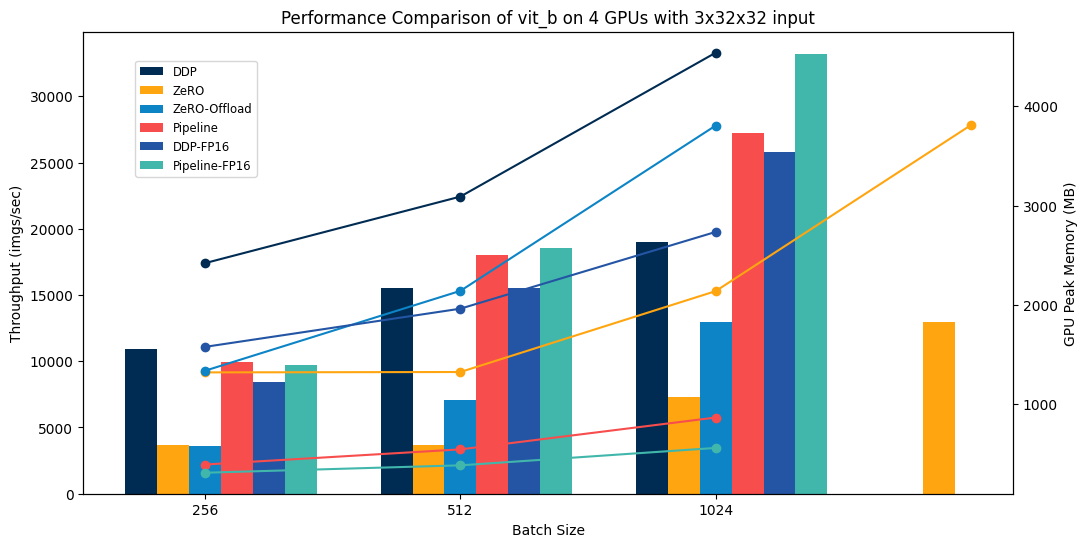

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


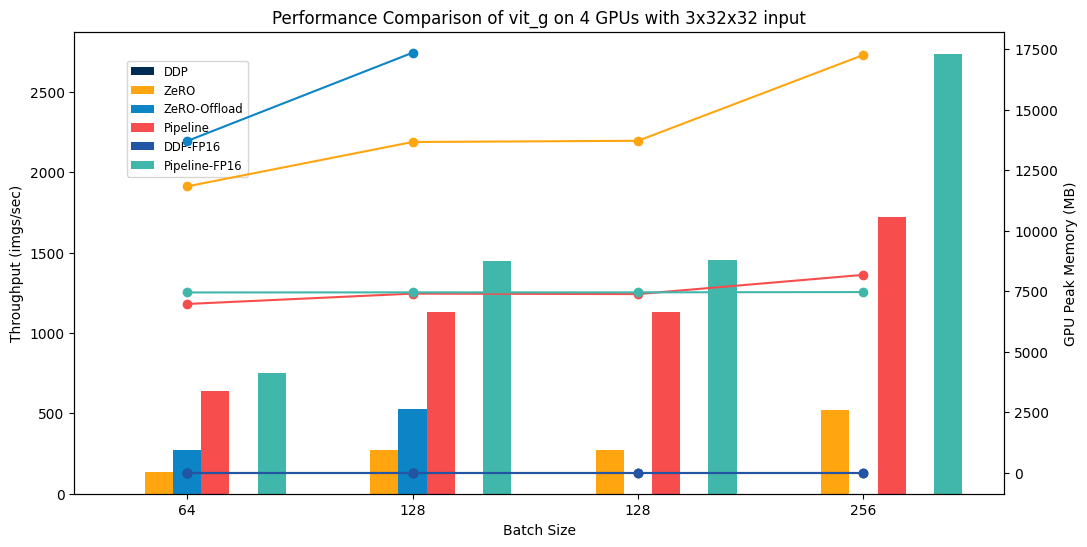

/tmp/ipykernel_5234/4005305266.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['model']==model_name][df1['gpus']==gpus][df1['img_size']==img_size].sort_values(by=['batch_size', 'zero', 'nof', 'pipeline', 'fp16'])


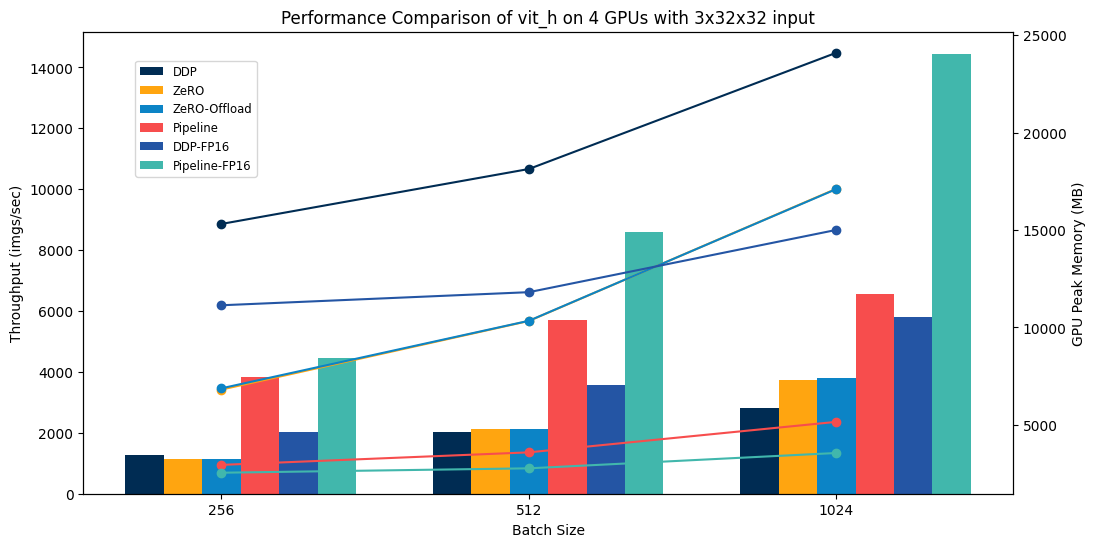

In [20]:
for model in new_df['model'].unique():
    try:
        plot(new_df, model, 4, 32)
    except Exception as e:
        print(f'error: {model} due to {e}')